In [24]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#PCA as best practice to reduce dimensionality first
#as well as check for fitting amount of Gaussians / clusters
from sklearn.decomposition import PCA

#kmeans (hard)
from sklearn.cluster import KMeans
#kmeans with expectation maximization (hard)
from sklearn.metrics import pairwise_distances_argmin
#GMM (soft)
from sklearn.mixture import GaussianMixture


In [18]:
path_output=os.path.join(os.getcwd(), '../data/output/')

## Data preparation

In [19]:
df = pd.read_csv(os.path.join(path_output, "Trips.csv"))

In [20]:
df = df.drop(['Unnamed: 0'], axis=1)

In [26]:
# df.info()
df.nunique()

df.datetime_start

p_bike_racks_start              3
p_spot_start                    2
p_booked_bikes_start            9
p_place_type_start              4
datetime_start             239006
b_number_start                604
p_uid_start                160086
p_bikes_start                  58
p_lat_start                 18361
b_electric_lock_start           2
b_bike_type_start               4
p_name_start                  776
p_free_racks_start              6
p_address_start              4402
b_lock_types_start              6
p_number_start                164
b_pedelec_battery_start         2
p_lng_start                 54518
b_boardcomputer_start         836
p_maintenance_start             2
p_terminal_type_start           4
p_bike_types_start            315
p_bike_racks_end                3
p_spot_end                      2
p_booked_bikes_end              7
p_place_type_end                4
datetime_end               235885
p_uid_end                  183845
p_bikes_end                    58
p_lat_end     

Text(0.5, 1.0, 'January')

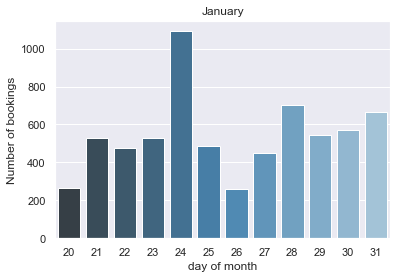

In [29]:
df["datetime_start"] = pd.to_datetime(df["datetime_start"].astype(str), format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_full = df
#Distribution Number of bookings per month
# df_full.datetime_start.dt.day.value_counts()
day_of_month_jan = df_full[df_full['datetime_start'].dt.month == 1].datetime_start.dt.day.value_counts()
ax = sns.barplot(x=day_of_month_jan.index, y=day_of_month_jan, palette="Blues_d")
ax.set(ylabel='Number of bookings', xlabel='day of month') 
ax.set_title('January')


## Task description - Cluster analysis

- Based on the bike rental demand patterns, can you identify clusters of **trip types and/or customer types**? 
- How would you **label** these clusters? 
- Can you identify **hot spots for vehicle availability and demand in spatial resolution**?
- Method 1: soft-clustering 
- Method 2: hard-clustering
- Create **visual comparison** of both methods 

#### Similar paper:
--> difference of usage patterns among user groups, turnover rate, travel time and distance
--> combined with spatial POI data with categories like: Catering, Hotel, Shopping, Living Service,
Tourist Sites, Leisure and Entertainment, Education, Medical, Trafficc Facilities, Financial Institutions,
Real Estate, Corporations, and Government Institutions.

### Columns for trip types:
- stations like University or main station
- trip duration
- bike IDs
- datetime
- weather data

### Columns for customer types:
- stations like University or main station
- trip duration
- user IDs
- datetime
- weather data

### Columns for spatial Vehicle availability & demand
- ??


## 1) Hard Clustering
- Kmeans: 
An iterative method, k-means algorithm is the most fundamental and most useful algorithm for
clustering [36]. For a given number of clusters, it can minimize the within-class sum of squares [37].
Its effciency to a great extent relies on the choice of the cluster centers. When the algorithm starts,
random procedures are applied to create starting clustering centers, then each observation is put
in its closest cluster. Therefore, the cluster centers are updated, and the entire process is repeated,
finally, objects are relocated by minimizing the distances of objects within clusters and maximizing the
distance of objects in different clusters.

- Expectation Maximization: 
A model-based clustering, EM clustering functions with a Gaussian mixture model. This model is
extended from the k-means algorithm [38]. K-means only takes into account the distance to the closest
cluster when assigning points to clusters. Yet EM clustering also computes the probability that a point
belongs to a cluster. As the probability depends on both the distance from the cluster center and the
spread (variance) of the cluster, a point that is closer to the centroid of one cluster than another may
well become more likely to belong to the latter cluster if it has a much higher spread [38].

## 2) Soft Clustering
- Gaussian Mixture Models:
Even more powerful than EM Clustering, can identify moonshaped clusters etc.

In [25]:
#standard kmeans approach
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)


ValueError: could not convert string to float: '2020-01-01 00:00:00'

In [ ]:
#advanced EM (kmeans) approach
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    # Choose randomly n_clusteres elements from the input list X
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        #print(labels)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [ ]:
#standrad GMM approach
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

#visualize probabilites
probs = gmm.predict_proba(X)
print(probs[:5].round(3))